In [44]:
from stellargraph.data import EdgeSplitter
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA
import stellargraph as sg
import matplotlib.pyplot as plt
import networkx as nx
import common_functions as cf
import random

In [9]:
G, mapper, reverse_mapper = cf.create_mapping_from_file_path('facebook/0.edges')

edge_splitter = EdgeSplitter(G)
splitted_graph, X, y = edge_splitter.train_test_split(p=0.2, method="global")

** Sampled 503 positive and 503 negative edges. **
Number of random walks for 'Graph': 33300


In [86]:
import random
import stellargraph as sg
from collections import Counter

def top_common_neighbors(graph):
    # Get all node ids in the graph
    all_node_ids = list(graph.nodes())

    # Initialize an empty dictionary to store the results
    result = {}

    # Iterate over each node in the graph
    for node in all_node_ids:
        # Get the neighbors of the node
        neighbors = list(graph.neighbors(node))

        # Count the number of common neighbors for each neighbor
        common_neighbors_counts = Counter([neighbor for n in neighbors for neighbor in graph.neighbors(n) if neighbor != node])

        # Get the top 5 nodes with the most common neighbors
        top_5 = [node_id for node_id, count in common_neighbors_counts.most_common(5)]

        # If the node has less than 5 neighbors, fill the remaining spots with random node ids
        while len(top_5) < 5:
            random_node = random.choice(all_node_ids)
            if random_node != node and random_node not in top_5:
                top_5.append(random_node)

        # Add the result to the dictionary
        result[node] = top_5

    return result

In [90]:
neighbor_dict = top_common_neighbors(splitted_graph)

In [122]:
# TODO 2-t külön szedni
# x1_score = []
# x2_score = []

predictions = []
for (x1, x2), y_ in zip(X,y):
    if y_ == 1:
        if x1 in neighbor_dict[x2] or x2 in neighbor_dict[x1]:
            predictions.append(1)
        else:
            predictions.append(0)
    else:
        if x1 in neighbor_dict[x2] or x2 in neighbor_dict[x1]:
            predictions.append(0)
        else:
            predictions.append(1)
            
    

In [123]:
predictions = np.array(predictions)

In [127]:
# import accuracy_score
from sklearn.metrics import accuracy_score

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y, predictions)

# Confusion Matrx
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y, predictions)

In [125]:
accuracy

0.1878727634194831

In [128]:
cm

array([[  5, 498],
       [319, 184]], dtype=int64)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def plot_normal_distribution(mu, sigma):
    # Create a range of numbers from -5 to 5
    x = np.linspace(-5, 5, 100)

    # Calculate the probability density function (PDF)
    y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

    # Plot the distribution
    plt.plot(x, y)
    plt.show()

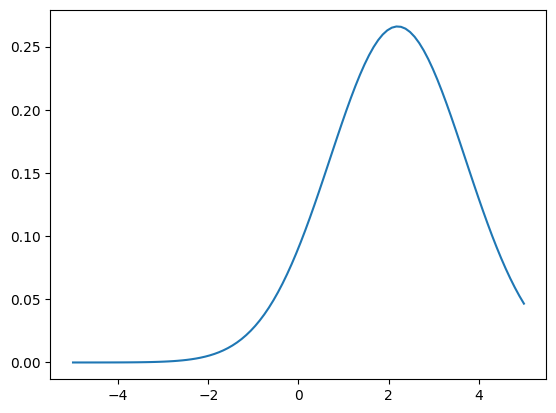

In [8]:
plot_normal_distribution(2.2, 1.5)

In [9]:
from scipy.stats import norm

# Parameters
mu = 2.2
sigma = 1.5
n = 50
x = 1

# Calculate the cumulative distribution function (CDF)
cdf = norm.cdf(x, mu, sigma)

# Calculate the number of elements less than 1
num_elements = n * cdf

print(f"The number of elements less than 1 is approximately {num_elements}")

The number of elements less than 1 is approximately 10.592769929169835


In [10]:
x1 = 12.3
x2 = 11.6
n1 = 10
n2 = 12
sigma = 18

(x1-x2)/np.sqrt(sigma**2*(1/n1+1/n2))

0.09082487681884448

In [18]:


from scipy.stats import chi2_contingency


In [19]:
A.sum(axis=0)

array([370,  40, 190])

In [27]:
# do a khi2 independence test

A = np.array([[56,4,20],[78,8,34], [236, 28, 136]])

n = A.sum()

chi_score = 0
for i in range(3):
    for j in range(3):
        chi_score += (A[i,j] - A.sum(axis=0)[i]*A.sum(axis=1)[j]/n) ** 2 / (A.sum(axis=0)[i]*A.sum(axis=1)[j]/n)

In [29]:
chi_score

3022.6843527738265

In [30]:
A = np.array([[56, 4, 20], [78, 8, 34], [236, 28, 136]])

n = A.sum()

# Calculate expected frequencies
expected = np.outer(A.sum(axis=1), A.sum(axis=0)) / n

# Calculate chi-squared statistic
chi_score = np.sum((A - expected)**2 / expected)

print("Chi-squared statistic:", chi_score)


Chi-squared statistic: 4.209957325746797


In [34]:
expected

array([[ 49.33333333,   5.33333333,  25.33333333],
       [ 74.        ,   8.        ,  38.        ],
       [246.66666667,  26.66666667, 126.66666667]])